## number of collection point 與 hk total recycling rate

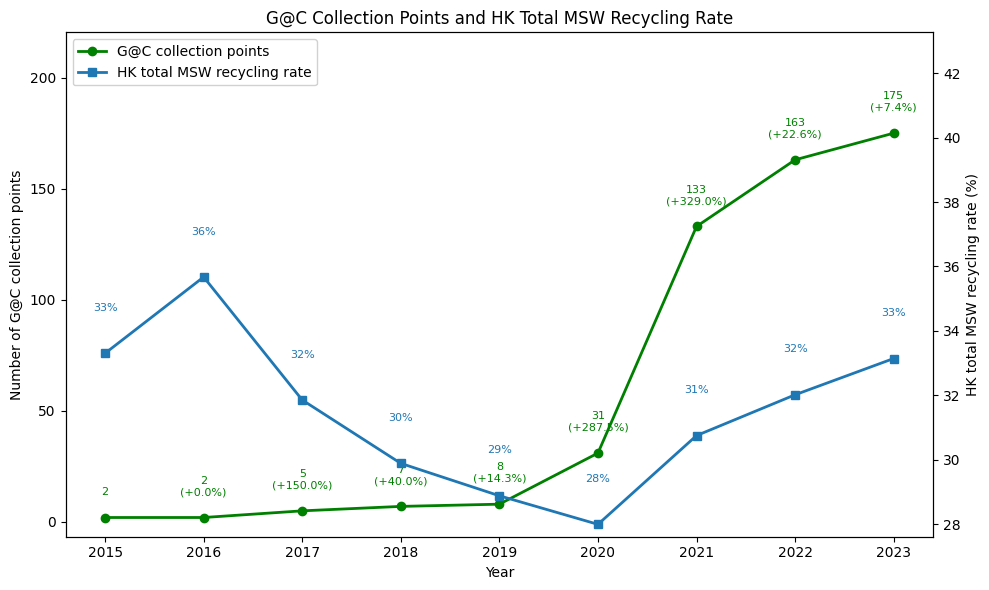

In [12]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys

def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("numpy")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

# ---------- load data ----------
data_path = Path("../General Stats_G@C_clean.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- select & clean the needed columns ----------
col_points = "Number of G@C collection points"
col_rate   = "HK total MSW recycling rate"

# keep only rows where both columns have data (drops blank rows at top)
mask = df[col_points].notna() & df[col_rate].notna()
sub = df.loc[mask, [col_points, col_rate]].copy()

# number of collection points
sub[col_points] = pd.to_numeric(sub[col_points], errors="coerce")

# recycling rate: read as float, strip "%" if present
rate_raw = sub[col_rate].astype(str).str.rstrip("%").replace("", np.nan).astype(float)

# if values are decimals (<= 1), convert to percentage; otherwise assume already in %
if rate_raw.max() <= 1.0:
    sub["recycling_rate_pct"] = rate_raw * 100.0   # e.g. 0.40 -> 40.0
else:
    sub["recycling_rate_pct"] = rate_raw           # e.g. 40.0 stays 40.0

# year-on-year increase in number of collection points (%)
sub["points_pct_change"] = sub[col_points].pct_change() * 100

# X-axis labels: use Year if available, otherwise simple sequence
if "Year" in df.columns:
    sub["Year"] = df.loc[sub.index, "Year"].astype(int).astype(str)
    x_labels = sub["Year"].tolist()
else:
    x_labels = [str(i + 1) for i in range(len(sub))]

x = np.arange(len(sub))

# ---------- plotting ----------
fig, ax1 = plt.subplots(figsize=(10, 6))

# Line 1: number of collection points (green)
line1, = ax1.plot(
    x,
    sub[col_points],
    marker="o",
    linewidth=2,
    color="green",
    label="G@C collection points",
)
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of G@C collection points", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=0)

# Add headroom so green labels don't hit the top
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.2)

# Label each GREEN point with value and % increase
y1_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
offset_points = y1_range * 0.04  # vertical gap between marker and label

for xi, yi, pct in zip(x, sub[col_points], sub["points_pct_change"]):
    if np.isnan(pct):
        label = f"{yi:,.0f}"
    else:
        label = f"{yi:,.0f}\n({pct:+.1f}%)"
    ax1.text(
        xi,
        yi + offset_points,
        label,
        ha="center",
        va="bottom",
        fontsize=8,
        color="green",
    )

# Line 2: HK total MSW recycling rate (blue, in %)
ax2 = ax1.twinx()
line2, = ax2.plot(
    x,
    sub["recycling_rate_pct"],
    marker="s",
    linestyle="-",
    linewidth=2,
    color="tab:blue",
    label="HK total MSW recycling rate",
)
ax2.set_ylabel("HK total MSW recycling rate (%)", color="black")
ax2.tick_params(axis="y", labelcolor="black")

# Format right y-axis as whole numbers (28, 30, 32, ...)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add headroom for blue labels
y2_min, y2_max = ax2.get_ylim()
ax2.set_ylim(y2_min, y2_max * 1.2)

y2_range = ax2.get_ylim()[1] - ax2.get_ylim()[0]
# >>> increased offset here to give more space between blue line and blue value <<<
offset_rate = y2_range * 0.08

# Label each BLUE point with the percentage value, e.g. "28%"
for xi, yi in zip(x, sub["recycling_rate_pct"]):
    ax2.text(
        xi,
        yi + offset_rate,
        f"{yi:.0f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        color="tab:blue",
    )

# Legend in top-left (so it doesn't cover data)
lines = [line1, line2]
labels = [l.get_label() for l in lines]
ax1.legend(
    lines,
    labels,
    loc="upper left",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
)

# Title and layout
plt.title(
    "G@C Collection Points and HK Total MSW Recycling Rate"
    
)

fig.tight_layout()
plt.show()
